# Upskilling a no-skill classifier with Conformal Prediction

Whenever a scientist needs to build a model, they need to evaluate the results against certain metrics given some context.

This led to a culture that focus too much on optimizing metrics instead of measuring how the model would impact the business.

In this notebook I'll show a way to evaluate models through different lens by using conformal prediction that can helps you given a clear picture of what your model is predicting.

In [1]:
import altair as alt
import numpy as np
import pandas as pd
from code_ramblings.models.conformal_prediction import ConformalClassifierEvaluator, ConformalClassifierModel
from code_ramblings.utils.data.blob_dataset import Blob, BlobDataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from utils import title

alt.data_transformers.enable("vegafusion")
alt.renderers.enable("svg")

start_alpha = 0.05
end_alpha = 0.95
num_alpha = int((end_alpha + start_alpha) / 0.05) - 1

alphas = np.linspace(start_alpha, end_alpha, num_alpha)
alphas = [round(i, 2) for i in alphas]


dataset = BlobDataset(
    blobs=[
        Blob(n_samples=20000, center=(0.0, 0.0), cluster_std=2.0),
        Blob(n_samples=1000, center=(3.0, 0.0), cluster_std=0.5),
        Blob(n_samples=1000, center=(1.0, 2.0), cluster_std=0.8),
    ]
)

df_train = dataset(0)
X_train, y_train = df_train[["x_0", "x_1"]], df_train["y"]
df_calib = dataset(1)
X_calib, y_calib = df_calib[["x_0", "x_1"]], df_calib["y"]
df_valid = dataset(2)
X_valid, y_valid = df_valid[["x_0", "x_1"]], df_valid["y"]


chart = (
    alt.Chart(df_train)
    .mark_point(size=10, opacity=0.5, filled=True)
    .encode(
        alt.X("x_0:Q").scale(domain=[-8, 8], clamp=True),
        alt.Y("x_1:Q").scale(domain=[-8, 8], clamp=True),
        alt.Color("y:N"),
    )
    .properties(
        title=title("Scatter over x_0/x_1 labeled by target y"),
        width=500,
        height=500,
    )
)

chart



From the image above one can already imagine that it will be very hard to correctly classify the label 1 while being almost impossible to do the same with label 2.

Some would say "upsampling" while others would say "downsampling". Upsampling is objectively bad, I'm not wasting my time on why it is bad to create artificial data. Downsampling on the other hand is ok, but it adds an extra layer of complexity that can't be avoided if you want correct results.

For this case I prefer Conformal Prediction. It's a method that helps you say something like "in this region of the feature space we expect this probability for each label" with mathematical grounding.

What does this means in practice?
 * for a targeted campaign this could mean "anyone from this region is sure to be at least interested in this ad" (remember that are cases in which we don't even have the capability of attending the whole demand for something, so if we can reduce our spending in marketing campaigns while still guaranteeing we sell the whole stock it is a big win);
 * on the other hand, if we are talking about fraud detection, we can use a cheaper model to detect anyone slightly suspicious and then send the results to a more sofisticated and expensive model that maybe is a paid API we contracted for our business, which means that we don't waste too many resources trying to detect frauds on most transactions.

## Logistic Regression Classifier

Training a Logistic Regression Classifier yields a model that can't classify no one beyonds label 0 correctly. However, it isn't a useless model like the metrics make it seems so.

Looking at the table calculated on the results of each set whe can see how the model is able to perform at each alpha. This give us the ability to analyze where our model is performing correctly with virtually 100% certainty that the label is correct while showing us at which threshold the models starts to "fail".

That means even a classically bad classifier can be useful if we don't have anything better.

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     20000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000

    accuracy                           0.90     22000
   macro avg       0.30      0.33      0.32     22000
weighted avg       0.83      0.90      0.86     22000

              precision    recall  f1-score   support

           0       0.97      0.76      0.85     20000
           1       0.34      0.83      0.48      1000
           2       0.18      0.72      0.29      1000

    accuracy                           0.76     22000
   macro avg       0.50      0.77      0.54     22000
weighted avg       0.91      0.76      0.81     22000



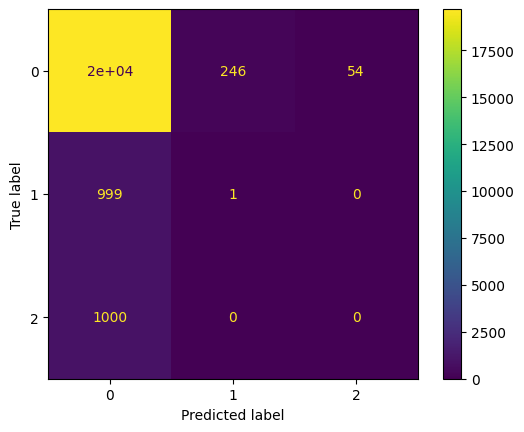

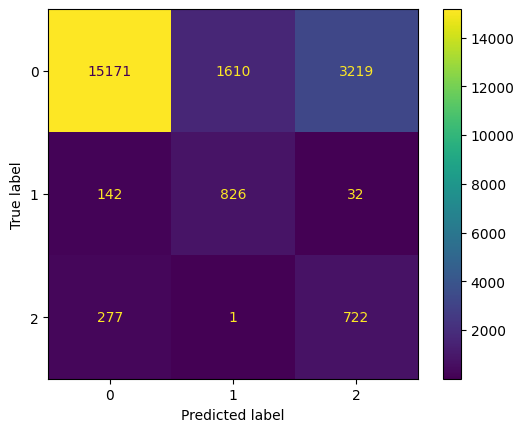

In [2]:
lr = ConformalClassifierModel(LogisticRegression(random_state=0))
lr.train(X_train, y_train)
lr.calibrate(X_calib, y_calib)

new_y_preds = lr.predict(X_valid, conformal=False)
print(classification_report(y_valid, new_y_preds))
ConfusionMatrixDisplay.from_predictions(y_valid, new_y_preds)

new_y_preds_conformal = lr.predict(X_valid, conformal=True)
print(classification_report(y_valid, new_y_preds_conformal))
ConfusionMatrixDisplay.from_predictions(y_valid, new_y_preds_conformal);

In [3]:
lr_cce = ConformalClassifierEvaluator(lr, X_valid, y_valid, alphas)
lr_cce.evaluate(0.05)

EvaluationMetrics(error=0.05122727272727268, avg_c=1.4648181818181818, one_c=0.5991363636363637, empty=0.0)

In [4]:
pd.DataFrame(lr_cce.calculate_coverage(alphas))

alpha  expected_coverage  coverage_rate  coverage_gap  covered_instances  \
0    0.05               0.95         0.9488       -0.0012              20873   
1    0.10               0.90         0.9010        0.0010              19823   
2    0.15               0.85         0.8542        0.0042              18793   
3    0.20               0.80         0.8041        0.0041              17690   
4    0.25               0.75         0.7549        0.0049              16607   
5    0.30               0.70         0.7053        0.0053              15516   
6    0.35               0.65         0.6565        0.0065              14444   
7    0.40               0.60         0.6022        0.0022              13248   
8    0.45               0.55         0.5516        0.0016              12135   
9    0.50               0.50         0.5002        0.0002              11005   
10   0.55               0.45         0.4506        0.0006               9913   
11   0.60               0.40         0.4010        0.0010               8822   
12   0.65               0.35         0.3510        0.0010               7721   
13   0.70               0.30         0.2979       -0.0021               6553   
14   0.75               0.25         0.2555        0.0055               5621   
15   0.80               0.20         0.2062        0.0062               4537   
16   0.85               0.15         0.1532        0.0032               3370   
17   0.90               0.10         0.1051        0.0051               2313   
18   0.95               0.05         0.0556        0.0056               1224   

    total_instances  avg_set_size  
0             22000          1.46  
1             22000          1.32  
2             22000          1.21  
3             22000          1.11  
4             22000          1.02  
5             22000          0.95  
6             22000          0.88  
7             22000          0.80  
8             22000          0.73  
9             22000          0.67  
10            22000          0.60  
11            22000          0.54  
12            22000          0.48  
13            22000          0.42  
14            22000          0.37  
15            22000          0.31  
16            22000          0.24  
17            22000          0.18  
18            22000          0.11

In [5]:
for i in range(3):
    display(pd.DataFrame(lr_cce.calculate_class_conditional_coverage(alphas, i)))

alpha  target_label  expected_coverage  coverage_rate  coverage_gap  \
0    0.05             0               0.95         0.9485       -0.0015   
1    0.10             0               0.90         0.9018        0.0018   
2    0.15             0               0.85         0.8548        0.0048   
3    0.20             0               0.80         0.8047        0.0047   
4    0.25             0               0.75         0.7548        0.0048   
5    0.30             0               0.70         0.7041        0.0041   
6    0.35             0               0.65         0.6543        0.0043   
7    0.40             0               0.60         0.6002        0.0002   
8    0.45             0               0.55         0.5491       -0.0010   
9    0.50             0               0.50         0.4988       -0.0012   
10   0.55             0               0.45         0.4505        0.0005   
11   0.60             0               0.40         0.4012        0.0012   
12   0.65             0               0.35         0.3508        0.0008   
13   0.70             0               0.30         0.2984       -0.0016   
14   0.75             0               0.25         0.2566        0.0066   
15   0.80             0               0.20         0.2072        0.0072   
16   0.85             0               0.15         0.1548        0.0048   
17   0.90             0               0.10         0.1050        0.0050   
18   0.95             0               0.05         0.0553        0.0052   

    covered_instances  target_instances  avg_set_size  
0               18969             20000          1.39  
1               18035             20000          1.27  
2               17096             20000          1.19  
3               16094             20000          1.10  
4               15095             20000          1.03  
5               14082             20000          0.95  
6               13086             20000          0.89  
7               12005             20000          0.81  
8               10981             20000          0.75  
9                9976             20000          0.68  
10               9010             20000          0.62  
11               8025             20000          0.56  
12               7015             20000          0.50  
13               5969             20000          0.43  
14               5133             20000          0.38  
15               4143             20000          0.32  
16               3097             20000          0.25  
17               2099             20000          0.18  
18               1105             20000          0.12

alpha  target_label  expected_coverage  coverage_rate  coverage_gap  \
0    0.05             1               0.95          0.960         0.010   
1    0.10             1               0.90          0.896        -0.004   
2    0.15             1               0.85          0.851         0.001   
3    0.20             1               0.80          0.804         0.004   
4    0.25             1               0.75          0.769         0.019   
5    0.30             1               0.70          0.733         0.033   
6    0.35             1               0.65          0.706         0.056   
7    0.40             1               0.60          0.649         0.049   
8    0.45             1               0.55          0.600         0.050   
9    0.50             1               0.50          0.531         0.031   
10   0.55             1               0.45          0.463         0.013   
11   0.60             1               0.40          0.399        -0.001   
12   0.65             1               0.35          0.348        -0.002   
13   0.70             1               0.30          0.285        -0.015   
14   0.75             1               0.25          0.233        -0.017   
15   0.80             1               0.20          0.194        -0.006   
16   0.85             1               0.15          0.139        -0.011   
17   0.90             1               0.10          0.107         0.007   
18   0.95             1               0.05          0.069         0.019   

    covered_instances  target_instances  avg_set_size  
0                 960              1000          2.52  
1                 896              1000          1.84  
2                 851              1000          1.32  
3                 804              1000          1.03  
4                 769              1000          0.88  
5                 733              1000          0.80  
6                 706              1000          0.75  
7                 649              1000          0.68  
8                 600              1000          0.61  
9                 531              1000          0.54  
10                463              1000          0.47  
11                399              1000          0.40  
12                348              1000          0.35  
13                285              1000          0.28  
14                233              1000          0.23  
15                194              1000          0.19  
16                139              1000          0.14  
17                107              1000          0.11  
18                 69              1000          0.07

alpha  target_label  expected_coverage  coverage_rate  coverage_gap  \
0    0.05             2               0.95          0.944        -0.006   
1    0.10             2               0.90          0.892        -0.008   
2    0.15             2               0.85          0.846        -0.004   
3    0.20             2               0.80          0.792        -0.008   
4    0.25             2               0.75          0.743        -0.007   
5    0.30             2               0.70          0.701         0.001   
6    0.35             2               0.65          0.652         0.002   
7    0.40             2               0.60          0.594        -0.006   
8    0.45             2               0.55          0.554         0.004   
9    0.50             2               0.50          0.498        -0.002   
10   0.55             2               0.45          0.440        -0.010   
11   0.60             2               0.40          0.398        -0.002   
12   0.65             2               0.35          0.358         0.008   
13   0.70             2               0.30          0.299        -0.001   
14   0.75             2               0.25          0.255         0.005   
15   0.80             2               0.20          0.200         0.000   
16   0.85             2               0.15          0.134        -0.016   
17   0.90             2               0.10          0.107         0.007   
18   0.95             2               0.05          0.050        -0.000   

    covered_instances  target_instances  avg_set_size  
0                 944              1000          1.99  
1                 892              1000          1.82  
2                 846              1000          1.61  
3                 792              1000          1.35  
4                 743              1000          1.11  
5                 701              1000          0.94  
6                 652              1000          0.80  
7                 594              1000          0.67  
8                 554              1000          0.59  
9                 498              1000          0.51  
10                440              1000          0.45  
11                398              1000          0.40  
12                358              1000          0.36  
13                299              1000          0.30  
14                255              1000          0.26  
15                200              1000          0.20  
16                134              1000          0.13  
17                107              1000          0.11  
18                 50              1000          0.05

In [6]:
for i in range(3):
    display(pd.DataFrame(lr_cce.calculate_class_conditional_precision(alphas, i)))

alpha  target_label  precision_rate  correct_predictions  \
0    0.05             0          0.9093                18969   
1    0.10             0          0.9263                18035   
2    0.15             0          0.9474                17096   
3    0.20             0          0.9637                16094   
4    0.25             0          0.9764                15095   
5    0.30             0          0.9841                14082   
6    0.35             0          0.9896                13086   
7    0.40             0          0.9949                12005   
8    0.45             0          0.9972                10981   
9    0.50             0          0.9988                 9976   
10   0.55             0          0.9994                 9010   
11   0.60             0          0.9998                 8025   
12   0.65             0          0.9999                 7015   
13   0.70             0          1.0000                 5969   
14   0.75             0          1.0000                 5133   
15   0.80             0          1.0000                 4143   
16   0.85             0          1.0000                 3097   
17   0.90             0          1.0000                 2099   
18   0.95             0          1.0000                 1105   

    sets_containing_target  total_instances  pp_gain_over_random  \
0                    20860            22000                 0.03   
1                    19469            22000                 1.73   
2                    18046            22000                 3.83   
3                    16701            22000                 5.46   
4                    15460            22000                 6.73   
5                    14310            22000                 7.50   
6                    13223            22000                 8.05   
7                    12067            22000                 8.58   
8                    11012            22000                 8.81   
9                     9988            22000                 8.97   
10                    9015            22000                 9.04   
11                    8027            22000                 9.07   
12                    7016            22000                 9.08   
13                    5969            22000                 9.09   
14                    5133            22000                 9.09   
15                    4143            22000                 9.09   
16                    3097            22000                 9.09   
17                    2099            22000                 9.09   
18                    1105            22000                 9.09   

    random_precision  
0             0.9091  
1             0.9091  
2             0.9091  
3             0.9091  
4             0.9091  
5             0.9091  
6             0.9091  
7             0.9091  
8             0.9091  
9             0.9091  
10            0.9091  
11            0.9091  
12            0.9091  
13            0.9091  
14            0.9091  
15            0.9091  
16            0.9091  
17            0.9091  
18            0.9091

alpha  target_label  precision_rate  correct_predictions  \
0    0.05             1          0.2617                  960   
1    0.10             1          0.2790                  896   
2    0.15             1          0.2899                  851   
3    0.20             1          0.2936                  804   
4    0.25             1          0.3002                  769   
5    0.30             1          0.3026                  733   
6    0.35             1          0.3078                  706   
7    0.40             1          0.3051                  649   
8    0.45             1          0.3026                  600   
9    0.50             1          0.2939                  531   
10   0.55             1          0.2786                  463   
11   0.60             1          0.2628                  399   
12   0.65             1          0.2468                  348   
13   0.70             1          0.2249                  285   
14   0.75             1          0.2023                  233   
15   0.80             1          0.1855                  194   
16   0.85             1          0.1557                  139   
17   0.90             1          0.1386                  107   
18   0.95             1          0.1053                   69   

    sets_containing_target  total_instances  pp_gain_over_random  \
0                     3668            22000                21.63   
1                     3212            22000                23.35   
2                     2936            22000                24.44   
3                     2738            22000                24.82   
4                     2562            22000                25.47   
5                     2422            22000                25.72   
6                     2294            22000                26.23   
7                     2127            22000                25.97   
8                     1983            22000                25.71   
9                     1807            22000                24.84   
10                    1662            22000                23.31   
11                    1518            22000                21.74   
12                    1410            22000                20.14   
13                    1267            22000                17.95   
14                    1152            22000                15.68   
15                    1046            22000                14.00   
16                     893            22000                11.02   
17                     772            22000                 9.31   
18                     655            22000                 5.99   

    random_precision  
0             0.0455  
1             0.0455  
2             0.0455  
3             0.0455  
4             0.0455  
5             0.0455  
6             0.0455  
7             0.0455  
8             0.0455  
9             0.0455  
10            0.0455  
11            0.0455  
12            0.0455  
13            0.0455  
14            0.0455  
15            0.0455  
16            0.0455  
17            0.0455  
18            0.0455

alpha  target_label  precision_rate  correct_predictions  \
0    0.05             2          0.1226                  944   
1    0.10             2          0.1383                  892   
2    0.15             2          0.1495                  846   
3    0.20             2          0.1592                  792   
4    0.25             2          0.1657                  743   
5    0.30             2          0.1721                  701   
6    0.35             2          0.1727                  652   
7    0.40             2          0.1732                  594   
8    0.45             2          0.1746                  554   
9    0.50             2          0.1721                  498   
10   0.55             2          0.1673                  440   
11   0.60             2          0.1639                  398   
12   0.65             2          0.1610                  358   
13   0.70             2          0.1483                  299   
14   0.75             2          0.1395                  255   
15   0.80             2          0.1288                  200   
16   0.85             2          0.1098                  134   
17   0.90             2          0.1056                  107   
18   0.95             2          0.0690                   50   

    sets_containing_target  total_instances  pp_gain_over_random  \
0                     7698            22000                 7.72   
1                     6452            22000                 9.28   
2                     5658            22000                10.41   
3                     4975            22000                11.37   
4                     4483            22000                12.03   
5                     4073            22000                12.67   
6                     3776            22000                12.72   
7                     3429            22000                12.78   
8                     3173            22000                12.91   
9                     2893            22000                12.67   
10                    2630            22000                12.18   
11                    2428            22000                11.85   
12                    2224            22000                11.55   
13                    2016            22000                10.29   
14                    1828            22000                 9.40   
15                    1553            22000                 8.33   
16                    1220            22000                 6.44   
17                    1013            22000                 6.02   
18                     725            22000                 2.35   

    random_precision  
0             0.0455  
1             0.0455  
2             0.0455  
3             0.0455  
4             0.0455  
5             0.0455  
6             0.0455  
7             0.0455  
8             0.0455  
9             0.0455  
10            0.0455  
11            0.0455  
12            0.0455  
13            0.0455  
14            0.0455  
15            0.0455  
16            0.0455  
17            0.0455  
18            0.0455

## Random Forest Classifier

Of course the Random Forest Classifier would perform way better than a Logistic Regression Classifier. However it still performs very bad, but the Conformal Prediction on top of it still gives way better control over the results.

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     20000
           1       0.63      0.57      0.60      1000
           2       0.31      0.11      0.16      1000

    accuracy                           0.91     22000
   macro avg       0.62      0.55      0.57     22000
weighted avg       0.89      0.91      0.90     22000

              precision    recall  f1-score   support

           0       0.98      0.82      0.89     20000
           1       0.50      0.88      0.64      1000
           2       0.22      0.77      0.34      1000

    accuracy                           0.82     22000
   macro avg       0.57      0.82      0.62     22000
weighted avg       0.92      0.82      0.86     22000



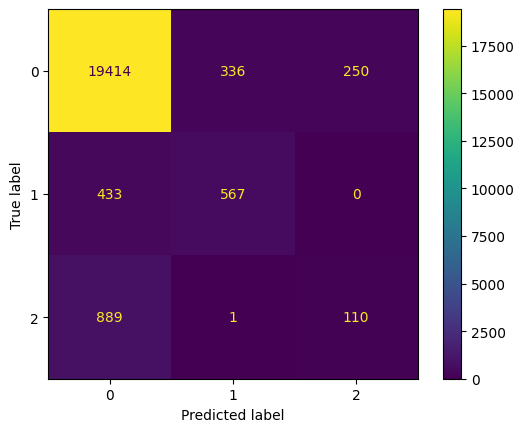

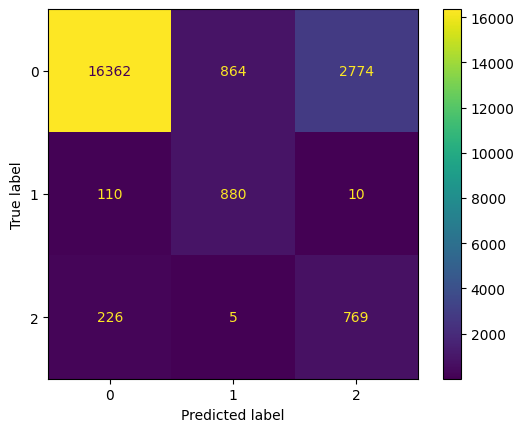

In [7]:
rf = ConformalClassifierModel(RandomForestClassifier(random_state=0))
rf.train(X_train, y_train)
rf.calibrate(X_calib, y_calib)

new_y_preds = rf.predict(X_valid, conformal=False)
print(classification_report(y_valid, new_y_preds))
ConfusionMatrixDisplay.from_predictions(y_valid, new_y_preds)

new_y_preds_conformal = rf.predict(X_valid, conformal=True)
print(classification_report(y_valid, new_y_preds_conformal))
ConfusionMatrixDisplay.from_predictions(y_valid, new_y_preds_conformal);

In [8]:
rf_cce = ConformalClassifierEvaluator(lr, X_valid, y_valid, alphas)
rf_cce.evaluate(0.05)

EvaluationMetrics(error=0.05122727272727268, avg_c=1.4648181818181818, one_c=0.5991363636363637, empty=0.0)

In [9]:
pd.DataFrame(rf_cce.calculate_coverage(alphas))

alpha  expected_coverage  coverage_rate  coverage_gap  covered_instances  \
0    0.05               0.95         0.9488       -0.0012              20873   
1    0.10               0.90         0.9010        0.0010              19823   
2    0.15               0.85         0.8542        0.0042              18793   
3    0.20               0.80         0.8041        0.0041              17690   
4    0.25               0.75         0.7549        0.0049              16607   
5    0.30               0.70         0.7053        0.0053              15516   
6    0.35               0.65         0.6565        0.0065              14444   
7    0.40               0.60         0.6022        0.0022              13248   
8    0.45               0.55         0.5516        0.0016              12135   
9    0.50               0.50         0.5002        0.0002              11005   
10   0.55               0.45         0.4506        0.0006               9913   
11   0.60               0.40         0.4010        0.0010               8822   
12   0.65               0.35         0.3510        0.0010               7721   
13   0.70               0.30         0.2979       -0.0021               6553   
14   0.75               0.25         0.2555        0.0055               5621   
15   0.80               0.20         0.2062        0.0062               4537   
16   0.85               0.15         0.1532        0.0032               3370   
17   0.90               0.10         0.1051        0.0051               2313   
18   0.95               0.05         0.0556        0.0056               1224   

    total_instances  avg_set_size  
0             22000          1.46  
1             22000          1.32  
2             22000          1.21  
3             22000          1.11  
4             22000          1.02  
5             22000          0.95  
6             22000          0.88  
7             22000          0.80  
8             22000          0.73  
9             22000          0.67  
10            22000          0.60  
11            22000          0.54  
12            22000          0.48  
13            22000          0.42  
14            22000          0.37  
15            22000          0.31  
16            22000          0.24  
17            22000          0.18  
18            22000          0.11

In [10]:
for i in range(3):
    display(pd.DataFrame(rf_cce.calculate_class_conditional_coverage(alphas, i)))

alpha  target_label  expected_coverage  coverage_rate  coverage_gap  \
0    0.05             0               0.95         0.9485       -0.0015   
1    0.10             0               0.90         0.9018        0.0018   
2    0.15             0               0.85         0.8548        0.0048   
3    0.20             0               0.80         0.8047        0.0047   
4    0.25             0               0.75         0.7548        0.0048   
5    0.30             0               0.70         0.7041        0.0041   
6    0.35             0               0.65         0.6543        0.0043   
7    0.40             0               0.60         0.6002        0.0002   
8    0.45             0               0.55         0.5491       -0.0010   
9    0.50             0               0.50         0.4988       -0.0012   
10   0.55             0               0.45         0.4505        0.0005   
11   0.60             0               0.40         0.4012        0.0012   
12   0.65             0               0.35         0.3508        0.0008   
13   0.70             0               0.30         0.2984       -0.0016   
14   0.75             0               0.25         0.2566        0.0066   
15   0.80             0               0.20         0.2072        0.0072   
16   0.85             0               0.15         0.1548        0.0048   
17   0.90             0               0.10         0.1050        0.0050   
18   0.95             0               0.05         0.0553        0.0052   

    covered_instances  target_instances  avg_set_size  
0               18969             20000          1.39  
1               18035             20000          1.27  
2               17096             20000          1.19  
3               16094             20000          1.10  
4               15095             20000          1.03  
5               14082             20000          0.95  
6               13086             20000          0.89  
7               12005             20000          0.81  
8               10981             20000          0.75  
9                9976             20000          0.68  
10               9010             20000          0.62  
11               8025             20000          0.56  
12               7015             20000          0.50  
13               5969             20000          0.43  
14               5133             20000          0.38  
15               4143             20000          0.32  
16               3097             20000          0.25  
17               2099             20000          0.18  
18               1105             20000          0.12

alpha  target_label  expected_coverage  coverage_rate  coverage_gap  \
0    0.05             1               0.95          0.960         0.010   
1    0.10             1               0.90          0.896        -0.004   
2    0.15             1               0.85          0.851         0.001   
3    0.20             1               0.80          0.804         0.004   
4    0.25             1               0.75          0.769         0.019   
5    0.30             1               0.70          0.733         0.033   
6    0.35             1               0.65          0.706         0.056   
7    0.40             1               0.60          0.649         0.049   
8    0.45             1               0.55          0.600         0.050   
9    0.50             1               0.50          0.531         0.031   
10   0.55             1               0.45          0.463         0.013   
11   0.60             1               0.40          0.399        -0.001   
12   0.65             1               0.35          0.348        -0.002   
13   0.70             1               0.30          0.285        -0.015   
14   0.75             1               0.25          0.233        -0.017   
15   0.80             1               0.20          0.194        -0.006   
16   0.85             1               0.15          0.139        -0.011   
17   0.90             1               0.10          0.107         0.007   
18   0.95             1               0.05          0.069         0.019   

    covered_instances  target_instances  avg_set_size  
0                 960              1000          2.52  
1                 896              1000          1.84  
2                 851              1000          1.32  
3                 804              1000          1.03  
4                 769              1000          0.88  
5                 733              1000          0.80  
6                 706              1000          0.75  
7                 649              1000          0.68  
8                 600              1000          0.61  
9                 531              1000          0.54  
10                463              1000          0.47  
11                399              1000          0.40  
12                348              1000          0.35  
13                285              1000          0.28  
14                233              1000          0.23  
15                194              1000          0.19  
16                139              1000          0.14  
17                107              1000          0.11  
18                 69              1000          0.07

alpha  target_label  expected_coverage  coverage_rate  coverage_gap  \
0    0.05             2               0.95          0.944        -0.006   
1    0.10             2               0.90          0.892        -0.008   
2    0.15             2               0.85          0.846        -0.004   
3    0.20             2               0.80          0.792        -0.008   
4    0.25             2               0.75          0.743        -0.007   
5    0.30             2               0.70          0.701         0.001   
6    0.35             2               0.65          0.652         0.002   
7    0.40             2               0.60          0.594        -0.006   
8    0.45             2               0.55          0.554         0.004   
9    0.50             2               0.50          0.498        -0.002   
10   0.55             2               0.45          0.440        -0.010   
11   0.60             2               0.40          0.398        -0.002   
12   0.65             2               0.35          0.358         0.008   
13   0.70             2               0.30          0.299        -0.001   
14   0.75             2               0.25          0.255         0.005   
15   0.80             2               0.20          0.200         0.000   
16   0.85             2               0.15          0.134        -0.016   
17   0.90             2               0.10          0.107         0.007   
18   0.95             2               0.05          0.050        -0.000   

    covered_instances  target_instances  avg_set_size  
0                 944              1000          1.99  
1                 892              1000          1.82  
2                 846              1000          1.61  
3                 792              1000          1.35  
4                 743              1000          1.11  
5                 701              1000          0.94  
6                 652              1000          0.80  
7                 594              1000          0.67  
8                 554              1000          0.59  
9                 498              1000          0.51  
10                440              1000          0.45  
11                398              1000          0.40  
12                358              1000          0.36  
13                299              1000          0.30  
14                255              1000          0.26  
15                200              1000          0.20  
16                134              1000          0.13  
17                107              1000          0.11  
18                 50              1000          0.05

In [11]:
for i in range(3):
    display(pd.DataFrame(rf_cce.calculate_class_conditional_precision(alphas, i)))

alpha  target_label  precision_rate  correct_predictions  \
0    0.05             0          0.9093                18969   
1    0.10             0          0.9263                18035   
2    0.15             0          0.9474                17096   
3    0.20             0          0.9637                16094   
4    0.25             0          0.9764                15095   
5    0.30             0          0.9841                14082   
6    0.35             0          0.9896                13086   
7    0.40             0          0.9949                12005   
8    0.45             0          0.9972                10981   
9    0.50             0          0.9988                 9976   
10   0.55             0          0.9994                 9010   
11   0.60             0          0.9998                 8025   
12   0.65             0          0.9999                 7015   
13   0.70             0          1.0000                 5969   
14   0.75             0          1.0000                 5133   
15   0.80             0          1.0000                 4143   
16   0.85             0          1.0000                 3097   
17   0.90             0          1.0000                 2099   
18   0.95             0          1.0000                 1105   

    sets_containing_target  total_instances  pp_gain_over_random  \
0                    20860            22000                 0.03   
1                    19469            22000                 1.73   
2                    18046            22000                 3.83   
3                    16701            22000                 5.46   
4                    15460            22000                 6.73   
5                    14310            22000                 7.50   
6                    13223            22000                 8.05   
7                    12067            22000                 8.58   
8                    11012            22000                 8.81   
9                     9988            22000                 8.97   
10                    9015            22000                 9.04   
11                    8027            22000                 9.07   
12                    7016            22000                 9.08   
13                    5969            22000                 9.09   
14                    5133            22000                 9.09   
15                    4143            22000                 9.09   
16                    3097            22000                 9.09   
17                    2099            22000                 9.09   
18                    1105            22000                 9.09   

    random_precision  
0             0.9091  
1             0.9091  
2             0.9091  
3             0.9091  
4             0.9091  
5             0.9091  
6             0.9091  
7             0.9091  
8             0.9091  
9             0.9091  
10            0.9091  
11            0.9091  
12            0.9091  
13            0.9091  
14            0.9091  
15            0.9091  
16            0.9091  
17            0.9091  
18            0.9091

alpha  target_label  precision_rate  correct_predictions  \
0    0.05             1          0.2617                  960   
1    0.10             1          0.2790                  896   
2    0.15             1          0.2899                  851   
3    0.20             1          0.2936                  804   
4    0.25             1          0.3002                  769   
5    0.30             1          0.3026                  733   
6    0.35             1          0.3078                  706   
7    0.40             1          0.3051                  649   
8    0.45             1          0.3026                  600   
9    0.50             1          0.2939                  531   
10   0.55             1          0.2786                  463   
11   0.60             1          0.2628                  399   
12   0.65             1          0.2468                  348   
13   0.70             1          0.2249                  285   
14   0.75             1          0.2023                  233   
15   0.80             1          0.1855                  194   
16   0.85             1          0.1557                  139   
17   0.90             1          0.1386                  107   
18   0.95             1          0.1053                   69   

    sets_containing_target  total_instances  pp_gain_over_random  \
0                     3668            22000                21.63   
1                     3212            22000                23.35   
2                     2936            22000                24.44   
3                     2738            22000                24.82   
4                     2562            22000                25.47   
5                     2422            22000                25.72   
6                     2294            22000                26.23   
7                     2127            22000                25.97   
8                     1983            22000                25.71   
9                     1807            22000                24.84   
10                    1662            22000                23.31   
11                    1518            22000                21.74   
12                    1410            22000                20.14   
13                    1267            22000                17.95   
14                    1152            22000                15.68   
15                    1046            22000                14.00   
16                     893            22000                11.02   
17                     772            22000                 9.31   
18                     655            22000                 5.99   

    random_precision  
0             0.0455  
1             0.0455  
2             0.0455  
3             0.0455  
4             0.0455  
5             0.0455  
6             0.0455  
7             0.0455  
8             0.0455  
9             0.0455  
10            0.0455  
11            0.0455  
12            0.0455  
13            0.0455  
14            0.0455  
15            0.0455  
16            0.0455  
17            0.0455  
18            0.0455

alpha  target_label  precision_rate  correct_predictions  \
0    0.05             2          0.1226                  944   
1    0.10             2          0.1383                  892   
2    0.15             2          0.1495                  846   
3    0.20             2          0.1592                  792   
4    0.25             2          0.1657                  743   
5    0.30             2          0.1721                  701   
6    0.35             2          0.1727                  652   
7    0.40             2          0.1732                  594   
8    0.45             2          0.1746                  554   
9    0.50             2          0.1721                  498   
10   0.55             2          0.1673                  440   
11   0.60             2          0.1639                  398   
12   0.65             2          0.1610                  358   
13   0.70             2          0.1483                  299   
14   0.75             2          0.1395                  255   
15   0.80             2          0.1288                  200   
16   0.85             2          0.1098                  134   
17   0.90             2          0.1056                  107   
18   0.95             2          0.0690                   50   

    sets_containing_target  total_instances  pp_gain_over_random  \
0                     7698            22000                 7.72   
1                     6452            22000                 9.28   
2                     5658            22000                10.41   
3                     4975            22000                11.37   
4                     4483            22000                12.03   
5                     4073            22000                12.67   
6                     3776            22000                12.72   
7                     3429            22000                12.78   
8                     3173            22000                12.91   
9                     2893            22000                12.67   
10                    2630            22000                12.18   
11                    2428            22000                11.85   
12                    2224            22000                11.55   
13                    2016            22000                10.29   
14                    1828            22000                 9.40   
15                    1553            22000                 8.33   
16                    1220            22000                 6.44   
17                    1013            22000                 6.02   
18                     725            22000                 2.35   

    random_precision  
0             0.0455  
1             0.0455  
2             0.0455  
3             0.0455  
4             0.0455  
5             0.0455  
6             0.0455  
7             0.0455  
8             0.0455  
9             0.0455  
10            0.0455  
11            0.0455  
12            0.0455  
13            0.0455  
14            0.0455  
15            0.0455  
16            0.0455  
17            0.0455  
18            0.0455